In [13]:
#needed to autoreload my functions
%load_ext autoreload

import json
import pickle

# import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#ML
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor



from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

import xgboost as xgb
from lightgbm import LGBMRegressor


import scipy as sp
## dont want warnings for final version
#import warnings
#warnings.filterwarnings("ignore")

#add this for auto reload my cuystom scripts
import sys
sys.path.append("..") ## to find my own libraries in src folder
# below I use param 1 to only reload funciton selected via %aimport. param 2 would reload everything
%autoreload 1
%aimport src.processing_functions
%aimport src.my_utils
from src import processing_functions as pf
from src import my_utils as mut



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import data

train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")
print(train.shape)
print(test.shape)

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# remove Id col for further preprocessing
train_noid=train.drop('Id',axis=1)
test_noid=test.drop('Id',axis=1)

print(train_noid.shape)
print(test_noid.shape)

# lets also combine train and test for preprocessing
train_nodv=train_noid.drop(columns=["SalePrice"])#remove dv to concatenate
# put dv aside
y=train["SalePrice"]
y_log=np.log(y)
# add info about the original set to which data belongs
tmp_train=train_nodv.copy()
tmp_train["set_id"]="train"
tmp_test=test_noid.copy()
tmp_test["set_id"]="test"
all_data=pd.concat([tmp_train,tmp_test])

all_data.shape


(1460, 81)
(1459, 80)
(1460, 80)
(1459, 79)


(2919, 80)

# 1. apply pipeline

In [3]:
# # the baseline pipeline
# #1.fill nas
# print("shape before ",all_data.shape)
# tmp=pf.fill_false_nas(all_data)
# tmp=pf.fill_true_nas(tmp)
# # 2. remove outliers
# tmp,y_no_out=pf.remove_outliers_picked(tmp,y)# extract y col wo outliers
# # 3.normalize num cols
# tmp=pf.normalize_min_max(tmp)
# # 4. transform distribution of num features
# tmp=pf.transform_distribution_features_simple(tmp)
# #5. deal with categorical variables
# tmp=pf.label_encoding_subset(tmp)
# print(tmp["set_id"])
# all_data_processed=pf.one_hot_encoding(tmp)
# all_data_processed.shape

In [4]:
# the robust scaling pipeline
#1.fill nas
print("shape before ",all_data.shape)
tmp=pf.fill_false_nas(all_data)
tmp=pf.fill_true_nas(tmp)
# 2. remove outliers
tmp,y_no_out=pf.remove_outliers_picked(tmp,y)# extract y col wo outliers
# 3. transform distribution of num features
tmp=pf.transform_distribution_features_simple(tmp)
#4. deal with categorical variables
tmp=pf.label_encoding_subset(tmp)
print(tmp["set_id"])
tmp=pf.one_hot_encoding(tmp)
# 5. robust scaling
all_data_processed=pf.normalize_robust(tmp)

all_data_processed.shape

shape before  (2919, 80)
0       train
1       train
2       train
3       train
4       train
        ...  
1454     test
1455     test
1456     test
1457     test
1458     test
Name: set_id, Length: 2917, dtype: object


(2917, 220)

## Split training and validation set

In [5]:
all_data_processed.shape

(2917, 220)

In [6]:
all_data_processed[all_data_processed["set_id"]=="train"].shape

#split training and test set
train_data_proc=all_data_processed[all_data_processed["set_id"]=="train"]
train_data_proc=train_data_proc.drop(columns=["set_id"])#rmv set_id col useless
test_data_proc=all_data_processed[all_data_processed["set_id"]=="test"]
# X_test=all_processed_data.drop(columns)
test_data_proc=test_data_proc.drop(columns=["set_id"])#rmv set_id col useless

print(train_data_proc.shape, test_data_proc.shape)


(1458, 219) (1459, 219)


In [7]:
y_no_out.shape

(1458,)

In [8]:
#apply log transform on dv
y_log=np.log(y_no_out)
X_train, X_val, y_train, y_val = train_test_split(train_data_proc, y_log, random_state=1,test_size=0.3)
print(X_train.shape,X_val.shape)

(1020, 219) (438, 219)


In [9]:
X_train_full=train_data_proc
y_train_full=y_log

# 2. train some models

## 2.1. XG boost

In [35]:
## just load model to save time
# the grid search for best params. beware, time consuming to run

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'alpha': [0, 0.1, 1],
    'lambda': [1, 1.5, 2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Train model with best parameters
best_params = grid_search.best_params_
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Save best params to a JSON file
with open('best_params_xgboost_rob_scaling.json', 'w') as f:
    json.dump(best_params, f)

with open('grid_search_xgboost_rob_scaling.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters found:  {'alpha': 0, 'colsample_bytree': 0.9, 'lambda': 1.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best score:  0.012939953049930194


In [27]:
with open('../models/best_params_xgboost.json', 'r') as f:
    xgb_best_params = json.load(f)

In [33]:
# instanciate model and fit
best_model = xgb.XGBRegressor(**xgb_best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Calculate RMSE for the training set
y_train_pred=best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

# Evaluate the model
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

final_xgb=best_model

Training RMSE:  0.06370901261609849
Validation RMSE:  0.12337456067651252


In [34]:
# save pred in submission file
y_pred = np.exp(final_xgb.predict(test_data_proc))

submission=pd.DataFrame({"Id":test["Id"],"SalePrice":y_pred})
submission
submission.to_csv("submission_XGboost_opti_robustscaling.csv",index=False)

try the new opti model

In [24]:
with open('../models/best_params_xgboost_rob_scaling.json', 'r') as f:
    xgb_best_params = json.load(f)

In [25]:
xgb_best_params

{'alpha': 0,
 'colsample_bytree': 0.9,
 'lambda': 1.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 0.8}

In [38]:
# instanciate model and fit
best_model = xgb.XGBRegressor(**xgb_best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Calculate RMSE for the training set
y_train_pred=best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

# Evaluate the model
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

final_xgb=best_model

Training RMSE:  0.04607811394515947
Validation RMSE:  0.1233204819070372


In [39]:
# save pred in submission file
y_pred = np.exp(final_xgb.predict(test_data_proc))

submission=pd.DataFrame({"Id":test["Id"],"SalePrice":y_pred})
submission
submission.to_csv("submission_XGboost_opti_robustscaling_newopti.csv",index=False)

Try to find one that dont overfit

In [49]:
new_params={'alpha': 0.01,
            'colsample_bytree': 0.9,
            'lambda': 1.5,
            'learning_rate': 0.1,
            'max_depth': 3,
            'n_estimators': 300,
            'subsample': 0.8}

In [53]:
# instanciate model and fit
best_model = xgb.XGBRegressor(**new_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Calculate RMSE for the training set
y_train_pred=best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

# Evaluate the model
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

final_xgb=best_model

Training RMSE:  0.04568340137658332
Validation RMSE:  0.12089301041981602


In [54]:
# save pred in submission file
y_pred = np.exp(final_xgb.predict(test_data_proc))

submission=pd.DataFrame({"Id":test["Id"],"SalePrice":y_pred})
submission
submission.to_csv("submission_XGboost_opti_robustscaling_newopti_alpha.csv",index=False)

In [44]:
# instanciate model and fit
alphas=[0,0.0001,0.001,0.01,0.02,0.05,0.1]
for e in alphas:
    print("alpha =  ",e  )
    best_model = xgb.XGBRegressor(**xgb_best_params,reg_alpha=e, objective='reg:squarederror', random_state=42)
    best_model.fit(X_train, y_train)
    
    # Calculate RMSE for the training set
    y_train_pred=best_model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    print("Training RMSE: ", rmse_train)
    
    # Evaluate the model
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    print("Validation RMSE: ", rmse)

alpha =   0
Training RMSE:  0.04607811394515947
Validation RMSE:  0.1233204819070372
alpha =   0.0001
Training RMSE:  0.04628208031566276
Validation RMSE:  0.12346976799606103
alpha =   0.001
Training RMSE:  0.04553848458108861
Validation RMSE:  0.12348277226847368
alpha =   0.01
Training RMSE:  0.04568340137658332
Validation RMSE:  0.12089301041981602
alpha =   0.02
Training RMSE:  0.04596490888014344
Validation RMSE:  0.12287699559423812
alpha =   0.05
Training RMSE:  0.04590662328277325
Validation RMSE:  0.12324874478409793
alpha =   0.1
Training RMSE:  0.046928947342372296
Validation RMSE:  0.12350417883474586


In [32]:
xgb_best_params

{'alpha': 0,
 'colsample_bytree': 0.7,
 'lambda': 1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 0.7}

In [40]:
xgb_best_params

{'alpha': 0,
 'colsample_bytree': 0.9,
 'lambda': 1.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 0.8}

In [ ]:
## let's do a new grid search, focusing on regularisation

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [ 300],
    'learning_rate': [0.05],
    'max_depth': [3,5],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'alpha': [0,0.001,0.01, 0.1, 1],
    'lambda': [1, 1.5, 2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Train model with best parameters
best_params = grid_search.best_params_
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Save best params to a JSON file
with open('best_params_xgboost.json', 'w') as f:
    json.dump(best_params, f)

with open('grid_search_xgboost.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

try non opti model from notebook

In [41]:
# non explicitely optimized model from nb

xgboost_base = xgb.XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

print('xgboost')
model_base = xgboost_base.fit(X_train, y_train)

y_train_pred=model_base.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

y_pred = model_base.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

xgboost
Training RMSE:  0.11462416488394507
Validation RMSE:  0.13840061178443666


## 2.2. lasso

In [14]:
# Define the model with LassoCV
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, random_state=42)

# Train the model with cross-validation
lasso_cv.fit(X_train, y_train)

# Get the best alpha value
best_alpha = lasso_cv.alpha_
print("Best alpha: ", best_alpha)

# Make predictions on the training set
y_train_pred = lasso_cv.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)

# Make predictions and evaluate the model
y_pred_cv = lasso_cv.predict(X_val)
mse_cv = mean_squared_error(y_val, y_pred_cv)
rmse_cv = np.sqrt(mse_cv)
print("Validation RMSE with best alpha: ", rmse_cv)

Best alpha:  0.0004498432668969444
Training RMSE:  0.09164976711016938
Validation RMSE with best alpha:  0.1208828447854436


In [15]:
# save pred in submission file
y_pred = np.exp(lasso_cv.predict(test_data_proc))

submission=pd.DataFrame({"Id":test["Id"],"SalePrice":y_pred})
submission
submission.to_csv("submission_Lasso_opti_robustscaling.csv",index=False)

## 2.3. ridge

In [51]:
kr = GridSearchCV(
    KernelRidge(kernel="poly"),
    # ## best
    # param_grid={"alpha": [0.0002782559402207126],
    #             "gamma": [0.0001]
     ## best
    param_grid={"alpha": np.logspace(np.log10(0.0001),np.log10(1),10),
                "degree": [2],
                "coef0":np.linspace(100,1000,10)
               },
)
kr.fit(X_train,y_train)

#check best parameters
print("Best parameters found: ", kr.best_params_)
print("Best cross-validation MSE: ", -kr.best_score_)

#predict training set
y_train_pred=kr.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)



# Evaluate the model on the validation set
y_val_pred = kr.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
print("Validation RMSE: ", rmse_val)


## save model and best params

kr_best_params =kr.best_params_

# Save best params to a JSON file
with open('../models/best_params_ridge.json', 'w') as f:
    json.dump(kr_best_params, f)

with open('../models/grid_search_ridge.pkl', 'wb') as f:
    pickle.dump(kr, f)


Best parameters found:  {'alpha': 1.0, 'coef0': 100.0, 'degree': 2}
Best cross-validation MSE:  -0.9174644543749075
Training RMSE:  0.08573643873736331
Validation RMSE:  0.12669797491545234


## 2.4. elastic net

In [55]:
from sklearn.linear_model import ElasticNet


# Define parameter grid
param_grid = {
    'alpha': np.logspace(np.log10(0.0001),np.log10(0.2),20),
    'l1_ratio': np.linspace(0.8, 1, 15)
}

# Instantiate mdoel
elastic_net = ElasticNet( )

# instantiate and fit grid search
elastic_net_cv = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elastic_net_cv.fit(X_train, y_train)

# Print best parameters and best score
elastic_net_best_params=elastic_net_cv.best_params_
print("Best parameters found: ", elastic_net_cv.best_params_)
print("Best cross-validation MSE: ", -elastic_net_cv.best_score_)



# Make predictions on the training set
y_train_pred = elastic_net_cv.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = elastic_net_cv.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

Best parameters found:  {'alpha': 0.0004953973547768393, 'l1_ratio': 1.0}
Best cross-validation MSE:  0.01228091982707741
Training RMSE:  0.0971481203792159
Validation RMSE:  0.12069546265589584


## 2.5 SVM

### parameter optimisation

In [ ]:
# ## little explo of params
# ### dammit, even this one is too long

# from sklearn.svm import SVR

# param_grid = {
#     'kernel': [ 'linear'],
#     'C': [0.1,1,10,20,30,40,50,100,500,1000],
#     'epsilon': [0.001, 0.01, 0.1, 0.5, 1.0]
#     #'gamma': ['scale', 'auto',0.00001,0.0001,0.001,0.01,0.1,1,5,10]  # Only for RBF kernel
# }
# # Instantiate SVM regressor
# svm_regressor = SVR()

# # Perform grid search
# grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print best parameters and best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation RMSE: ", -grid_search.best_score_)

# # Make predictions on the training set
# y_train_pred = grid_search.predict(X_train)
# # Calculate RMSE for the training set
# mse_train = mean_squared_error(y_train, y_train_pred)
# rmse_train = np.sqrt(mse_train)
# print("Training RMSE: ", rmse_train)


# # Make predictions and evaluate the model
# y_pred = grid_search.predict(X_val)
# mse = mean_squared_error(y_val, y_pred)
# rmse = np.sqrt(mse)
# print("Validation RMSE: ", rmse)

exception calling callback for <Future at 0x20534dfb610 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\joblib\parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
          ^^^^^^^

In [34]:
## smaller
### dammit still too big
from sklearn.svm import SVR

param_grid = {
    'kernel': [ 'rbf'],
    'C': [10,18,20,22,30],
    'epsilon': [0.001, 0.01,0.02,0.03],
    'gamma':[0.0001,0.0005,0.0006,0.0007,0.0008]
    #'gamma': ['scale', 'auto',0.00001,0.0001,0.001,0.01,0.1,1,5,10]  # Only for RBF kernel
}
# Instantiate SVM regressor
svm_regressor = SVR()

# Perform grid search
grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation RMSE: ", -grid_search.best_score_)

# Make predictions on the training set
y_train_pred = grid_search.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

Best parameters found:  {'C': 22, 'epsilon': 0.02, 'gamma': 0.0005, 'kernel': 'rbf'}
Best cross-validation RMSE:  0.10730966005991405
Training RMSE:  0.07647272681281253
Validation RMSE:  0.1245469220640042


In [24]:
## try other implementation of linear svm
### dammit still too big
from sklearn.svm import LinearSVR

param_grid = {
    'C': [0.2,0.5,1,10,20,30,50,100],
    'epsilon': [0,0.006,0.001, 0.01, 0.1,0.2,0.5,0.8],
    'max_iter': [1000, 5000, 10000, 50000, 100000]
    #'gamma': ['scale', 'auto',0.00001,0.0001,0.001,0.01,0.1,1,5,10]  # Only for RBF kernel
}
# Instantiate SVM regressor
svm_regressor = LinearSVR()

# Perform grid search
grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation RMSE: ", -grid_search.best_score_)

# Make predictions on the training set
y_train_pred = grid_search.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best parameters found:  {'C': 1, 'epsilon': 0.01, 'max_iter': 10000}
Best cross-validation RMSE:  0.12243945400856829
Training RMSE:  0.0908423302761056
Validation RMSE:  0.16925715727668034


C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [25]:
# Save best params to a JSON file
with open('best_params_linSVR.json', 'w') as f:
    json.dump(grid_search.best_params_, f)

with open('grid_search_linsvr.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

try to optimize further with narrower range of parameters

In [13]:
## preset params
# Instantiate and train the SVM regression model
svm = SVR( C= 20, epsilon= 0.008, gamma=0.0003)
svm.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = svm.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = svm.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)



Training RMSE:  0.08551540626597512
Validation RMSE:  0.12450895093493639


## 2.6. random forest

In [17]:
# out of the box
# instantiate and fit model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train,y_train)

# Make predictions on the training set
y_train_pred = rf.predict(X_train)

# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)


Training RMSE:  0.05174551785045563
Validation RMSE:  0.14415747566012954


In [10]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")



# Make predictions on the training set
y_train_pred = grid_search.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)





Fitting 5 folds for each of 864 candidates, totalling 4320 fits


C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
434 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_p

Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best cross-validation score: 0.8817
Training RMSE:  1.660397841180649e-13
Validation RMSE:  0.1376353185962047


In [11]:
### smaller param search

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [800, 1000,1200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4,6],
    'max_features': ['auto', 'sqrt', 'log2',None],
    'bootstrap': [True]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")



# Make predictions on the training set
y_train_pred = grid_search.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)





Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
185 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\allst\anaconda3\envs\datascience\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_pa

Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Best cross-validation score: 0.8834
Training RMSE:  0.05933997796288586
Validation RMSE:  0.14210234304891659


In [18]:
Best_parameters_rf= {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

# Save best params to a JSON file
with open('../models/best_params_random_forest.json', 'w') as f:
    json.dump(Best_parameters_rf, f)

# with open('../models/grid_search_random forest.pkl', 'wb') as f:
#     pickle.dump(grid_search, f)

### preset

In [16]:
# presets from nb

rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# fit model
rf.fit(X_train, y_train)




# Make predictions on the training set
y_train_pred = rf.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)


Training RMSE:  0.08803241847253461
Validation RMSE:  0.14649858853102518


## 2.7. light gradient boost

### out of the box

In [19]:
lgbm = LGBMRegressor(objective='regression',
                     random_state=42)


# fit model
lgbm.fit(X_train, y_train)




# Make predictions on the training set
y_train_pred = lgbm.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = lgbm.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3000
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 131
[LightGBM] [Info] Start training from score 12.029161
Training RMSE:  0.036658267184670704
Validation RMSE:  0.1357973242190268


### try opti

In [21]:

# big parameter search
# Define the model
lgbm = LGBMRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")



# Make predictions on the training set
y_train_pred = grid_search.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)


# Save best params to a JSON file
with open('../models/best_params_lgbm_robscal.json', 'w') as f:
    json.dump(grid_search.best_params_, f)

with open('../models/grid_search_lgbm_robscal.pkl', 'wb') as f:
    pickle.dump(grid_search, f)


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


KeyboardInterrupt: 

In [22]:
# smaller parameter search
# Define the model
lgbm = LGBMRegressor(objective='regression',random_state=42)

# Define the parameter grid
param_grid = {
    'num_leaves': [2,4,7],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [-1, 5,],
    'n_estimators': [500, 1000,5000],
    'min_child_samples': [ 10, 20,30],
    'subsample': [ 0.8, 1.0],
    'colsample_bytree': [ 0.8, 1.0],
    'max_bin':[180,200],
    'bagging_fraction':[0.75,0.85],
    'bagging_freq':[5,7],
    'feature_fraction':[0.2,0.1],
    'bagging_seed':[7],
    'feature_fraction_seed':[7]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")



# Make predictions on the training set
y_train_pred = grid_search.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)


# Save best params to a JSON file
with open('../models/best_params_lgbm_robscal.json', 'w') as f:
    json.dump(grid_search.best_params_, f)

with open('../models/grid_search_lgbm_robscal.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits


KeyboardInterrupt: 

In [23]:
# smaller parameter search
# Define the model
lgbm = LGBMRegressor(objective='regression',random_state=42)

# Define the parameter grid
param_grid = {
    'num_leaves': [2,4,7],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [-1],
    'n_estimators': [4000,5000],
    'min_child_samples': [ 20],
    'subsample': [ 0.8, 1.0],
    'colsample_bytree': [ 0.8, 1.0],
    'max_bin':[200],
    'bagging_fraction':[0.75,0.85],
    'bagging_freq':[5,7],
    'feature_fraction':[0.2,0.1],
    'bagging_seed':[7],
    'feature_fraction_seed':[7]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")



# Make predictions on the training set
y_train_pred = grid_search.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = grid_search.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)


# Save best params to a JSON file
with open('../models/best_params_lgbm_robscal.json', 'w') as f:
    json.dump(grid_search.best_params_, f)

with open('../models/grid_search_lgbm_robscal.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.8 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.8 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005108 seconds.
You can set `force_col_wise=true` to remove the ov

### preset

In [20]:
lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )


# fit model
lgbm.fit(X_train, y_train)




# Make predictions on the training set
y_train_pred = lgbm.predict(X_train)
# Calculate RMSE for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Training RMSE: ", rmse_train)


# Make predictions and evaluate the model
y_pred = lgbm.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE: ", rmse)

Training RMSE:  0.06659247011787978
Validation RMSE:  0.12390150861419673


# 3. blending

## 31 3 models

In [46]:
#eval blended predictions on validation set

# Make predictions with each model
preds_kr = kr.predict(X_val)
preds_lasso_cv = lasso_cv.predict(X_val)
preds_final_xgb = final_xgb.predict(X_val)

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,], axis=0)

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, blended_preds)
rmse_val = np.sqrt(mse_val)
print("Validation RMSE: ", rmse_val)


Validation RMSE:  0.1171359948825713


In [42]:
# make pred and save in submission file

preds_kr = np.exp(kr.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_cv.predict(test_data_proc))
preds_final_xgb = np.exp(final_xgb.predict(test_data_proc))

blended_preds = np.mean([preds_kr, preds_lasso_cv, preds_final_xgb], axis=0)

# print(len(y_pred),len(test_data_proc))
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_xgb,kr,lasso.csv",index=False)

## use full training set

In [59]:
xgb_best = xgb.XGBRegressor(**xgb_best_params, objective='reg:squarederror', random_state=42)
xgb_best.fit(X_train_full, y_train_full)




XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, ...)

In [56]:
elastic_net_best = ElasticNet(**elastic_net_best_params )
elastic_net_best.fit(X_train_full, y_train_full)


ElasticNet(alpha=0.0004953973547768393, l1_ratio=1.0)

In [57]:
kr_best=KernelRidge(**kr_best_params)
kr_best.fit(X_train_full, y_train_full)

KernelRidge(alpha=1.0, coef0=100.0, degree=2)

In [60]:
lasso_best=Lasso(best_alpha)
lasso_best.fit(X_train_full, y_train_full)

Lasso(alpha=0.0004498432668969444)

In [61]:
## for 4 models
# Make the preds for test set and save them
# Make predictions with each model
preds_kr = np.exp(kr_best.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_best.predict(test_data_proc))
preds_final_xgb = np.exp(xgb_best.predict(test_data_proc))
preds_elastic_net_cv=np.exp(elastic_net_best.predict(test_data_proc))

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,
                         preds_elastic_net_cv], axis=0)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_xgb,kr,lasso,elast_fulltrain.csv",index=False)


In [62]:
## for 3 models
# Make the preds for test set and save them
# Make predictions with each model
preds_kr = np.exp(kr_best.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_best.predict(test_data_proc))
preds_final_xgb = np.exp(xgb_best.predict(test_data_proc))

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,], axis=0)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_xgb,kr,lasso_fulltrain.csv",index=False)


## 4 models

In [47]:
#eval blended predictions on validation set

# Make predictions with each model
preds_kr = kr.predict(X_val)
preds_lasso_cv = lasso_cv.predict(X_val)
preds_final_xgb = final_xgb.predict(X_val)
preds_elastic_net_cv=elastic_net_cv.predict(X_val)

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,
                         preds_elastic_net_cv], axis=0)

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, blended_preds)
rmse_val = np.sqrt(mse_val)
print("Validation RMSE: ", rmse_val)


Validation RMSE:  0.11750394083510789


In [48]:
# Make predictions with each model
preds_kr = np.exp(kr.predict(test_data_proc))
preds_lasso_cv = np.exp(lasso_cv.predict(test_data_proc))
preds_final_xgb = np.exp(final_xgb.predict(test_data_proc))
preds_elastic_net_cv=np.exp(elastic_net_cv.predict(test_data_proc))

blended_preds = np.mean([preds_kr,
                         preds_lasso_cv,
                         preds_final_xgb,
                         preds_elastic_net_cv], axis=0)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":blended_preds})
submission
submission.to_csv("submission_blended_xgb,kr,lasso,elast.csv",index=False)


# 4. stacking

## regression. training set

In [65]:
from sklearn.linear_model import LinearRegression

# Generate predictions from each base model on the training set
kr_train_pred = kr_best.predict(X_train)
xgb_train_pred = xgb_best.predict(X_train)
lasso_train_pred = lasso_best.predict(X_train)
elastic_net_train_pred = elastic_net_best.predict(X_train)

# Stack predictions to create a new feature set for the meta-model
stacked_train_pred = np.column_stack((kr_train_pred, xgb_train_pred, lasso_train_pred, elastic_net_train_pred))

# Train the meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_train_pred, y_train)

# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(X_val)
xgb_test_pred = xgb_best.predict(X_val)
lasso_test_pred = lasso_best.predict(X_val)
elastic_net_test_pred = elastic_net_best.predict(X_val)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# Evaluate the performance of the stacked model
mse_val = mean_squared_error(y_val, final_predictions)
rmse_val = np.sqrt(mse_val)
print(f"Test RMSE of the stacked model: {test_rmse}")

Test RMSE of the stacked model: 0.07675538295317386


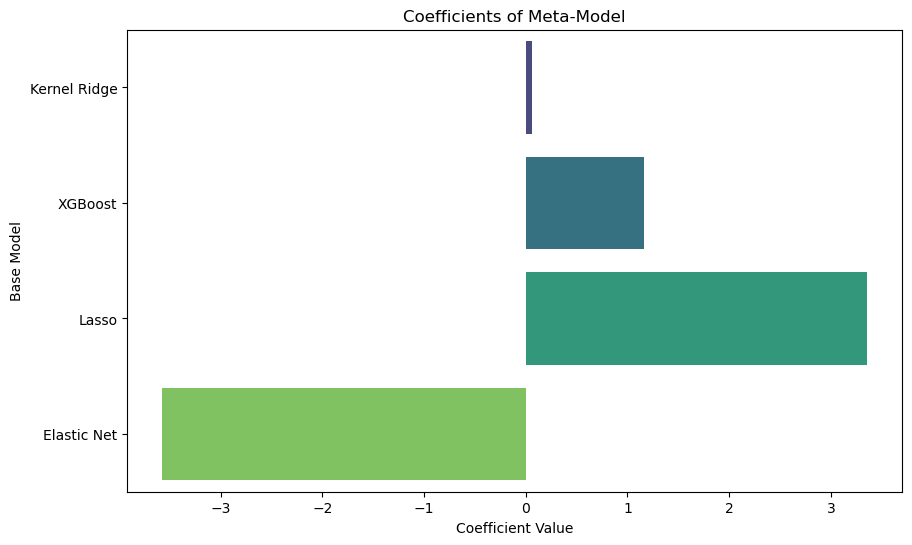

In [66]:
# Extract the coefficients of the meta-model
coefficients = meta_model.coef_
base_models = ['Kernel Ridge', 'XGBoost', 'Lasso', 'Elastic Net']

# Create a DataFrame for better visualization
import pandas as pd
coeff_df = pd.DataFrame({'Base Model': base_models, 'Coefficient': coefficients})

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Base Model', data=coeff_df, palette='viridis')
plt.title('Coefficients of Meta-Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Base Model')
plt.show()

In [67]:
## use this meta learner for the pred on test set
## and save preds for submission
# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(test_data_proc)
xgb_test_pred = xgb_best.predict(test_data_proc)
lasso_test_pred = lasso_best.predict(test_data_proc)
elastic_net_test_pred = elastic_net_best.predict(test_data_proc)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":np.exp(final_predictions)})
submission
submission.to_csv("submission_stacked_4mods.csv",index=False)


regression valid set

In [70]:
from sklearn.linear_model import LinearRegression

# Generate predictions from each base model on the training set
kr_val_pred = kr_best.predict(X_val)
xgb_val_pred = xgb_best.predict(X_val)
lasso_val_pred = lasso_best.predict(X_val)
elastic_net_val_pred = elastic_net_best.predict(X_val)

# Stack predictions to create a new feature set for the meta-model
stacked_val_pred = np.column_stack((kr_val_pred, xgb_val_pred, lasso_val_pred, elastic_net_val_pred))

# Train the meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_val_pred, y_val)

stacked_val_pred=meta_model.predict(stacked_val_pred)



# Evaluate the performance of the stacked model
mse_val = mean_squared_error(y_val, stacked_val_pred)
rmse_val = np.sqrt(mse_val)
print(f"Test RMSE of the stacked model: {test_rmse}")

Test RMSE of the stacked model: 0.07675538295317386


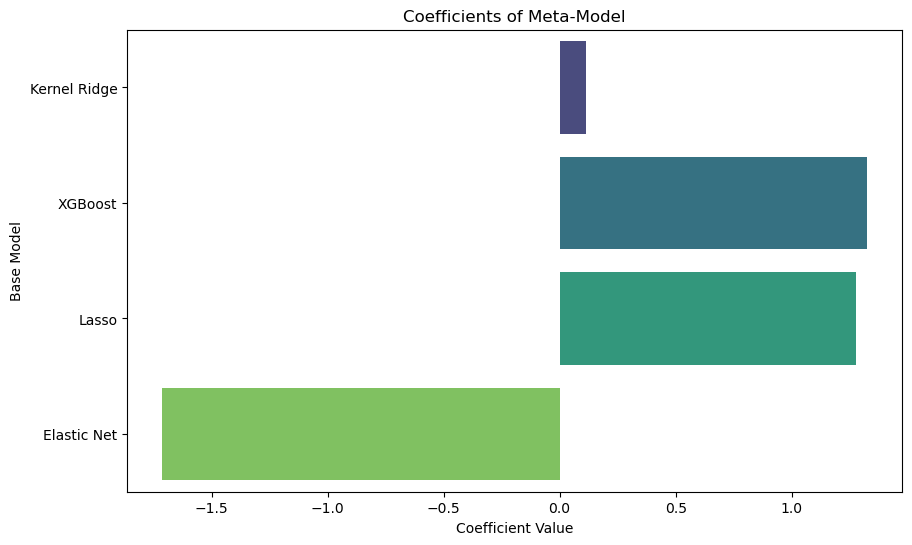

In [71]:
# Extract the coefficients of the meta-model
coefficients = meta_model.coef_
base_models = ['Kernel Ridge', 'XGBoost', 'Lasso', 'Elastic Net']

# Create a DataFrame for better visualization
import pandas as pd
coeff_df = pd.DataFrame({'Base Model': base_models, 'Coefficient': coefficients})

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Base Model', data=coeff_df, palette='viridis')
plt.title('Coefficients of Meta-Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Base Model')
plt.show()

In [72]:
## use this meta learner for the pred on test set
## and save preds for submission
# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(test_data_proc)
xgb_test_pred = xgb_best.predict(test_data_proc)
lasso_test_pred = lasso_best.predict(test_data_proc)
elastic_net_test_pred = elastic_net_best.predict(test_data_proc)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":np.exp(final_predictions)})
submission
submission.to_csv("submission_stacked_4mods_val.csv",index=False)


## lets try a lasso meta learner

In [82]:

# Generate predictions from each base model on the training set
kr_train_pred = kr_best.predict(X_train)
xgb_train_pred = xgb_best.predict(X_train)
lasso_train_pred = lasso_best.predict(X_train)
elastic_net_train_pred = elastic_net_best.predict(X_train)

# Stack predictions to create a new feature set for the meta-model
stacked_train_pred = np.column_stack((kr_train_pred, xgb_train_pred, lasso_train_pred, elastic_net_train_pred))

# Train the meta-model
meta_model = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, random_state=42)

meta_model.fit(stacked_train_pred, y_train)
print(meta_model.alpha_)


# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(X_val)
xgb_test_pred = xgb_best.predict(X_val)
lasso_test_pred = lasso_best.predict(X_val)
elastic_net_test_pred = elastic_net_best.predict(X_val)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# Evaluate the performance of the stacked model
mse_val = mean_squared_error(y_val, final_predictions)
rmse_val = np.sqrt(mse_val)
print(f"Test RMSE of the stacked model: {test_rmse}")

0.0001
Test RMSE of the stacked model: 0.07675538295317386


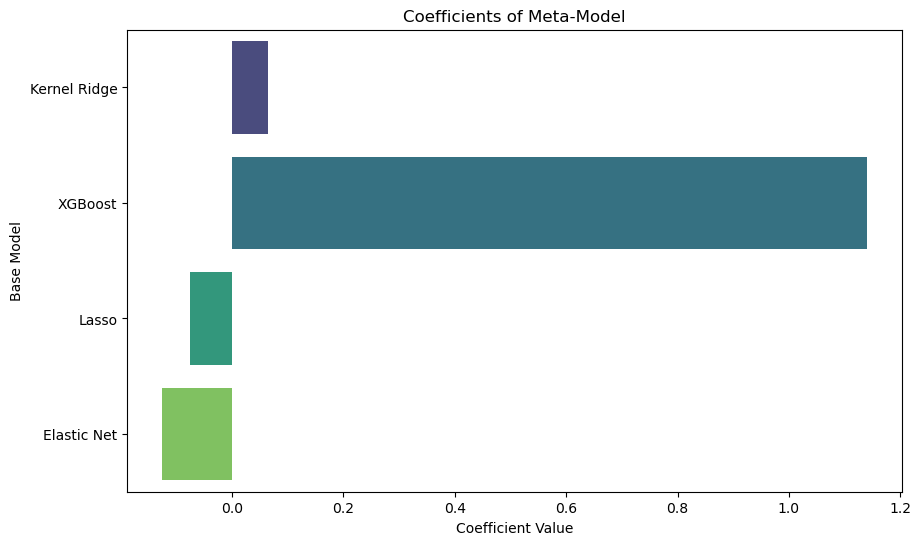

In [83]:
# Extract the coefficients of the meta-model
coefficients = meta_model.coef_
base_models = ['Kernel Ridge', 'XGBoost', 'Lasso', 'Elastic Net']

# Create a DataFrame for better visualization
import pandas as pd
coeff_df = pd.DataFrame({'Base Model': base_models, 'Coefficient': coefficients})

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Base Model', data=coeff_df, palette='viridis')
plt.title('Coefficients of Meta-Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Base Model')
plt.show()

In [84]:
## use this meta learner for the pred on test set
## and save preds for submission
# Generate predictions from each base model on the test set
kr_test_pred = kr_best.predict(test_data_proc)
xgb_test_pred = xgb_best.predict(test_data_proc)
lasso_test_pred = lasso_best.predict(test_data_proc)
elastic_net_test_pred = elastic_net_best.predict(test_data_proc)

# Stack predictions to create a new feature set for the meta-model
stacked_test_pred = np.column_stack((kr_test_pred, xgb_test_pred, lasso_test_pred, elastic_net_test_pred))

# Make final predictions using the meta-model
final_predictions = meta_model.predict(stacked_test_pred)

# save submission file
submission=pd.DataFrame({"Id":test["Id"],"SalePrice":np.exp(final_predictions)})
submission
submission.to_csv("submission_stacked_4mods_lassometa.csv",index=False)


array([0., 0., 0., 0.])